In [ ]:
from google.colab import drive
drive.mount('/content/drive') #connect your drive to notebook

# Video Capturing  ( Siteden Video Çekme )

With this, we collected IBB Webcam videos for the final predictions.

In [ ]:
import cv2
import numpy as np

In [ ]:
# Create a VideoCapture object
cap = cv2.VideoCapture("http://ibb-media1.ibb.gov.tr:1935/hls/297.stream/playlist.m3u8")

In [ ]:
if (cap.isOpened() == False): 
  print("Unable to read camera feed")

In [ ]:
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

In [ ]:
out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
while(True):
  ret, frame = cap.read()

  if ret == True: 
    
    # Write the frame into the file 'output.avi'
    out.write(frame)

    # Display the resulting frame    
    cv2.imshow('frame',frame)

    # Press Q on keyboard to stop recording
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

  # Break the loop
  else:
    break  

# When everything done, release the video capture and video write objects
cap.release()
out.release()

# Closes all the frames
cv2.destroyAllWindows() 

# YOLOV4

* YOLOV4tiny Model is referenced by Enis Getmez POI project.
* Test was done on IBB Şehir Camera Videos.
* Turning the pre-trained YOLOV4 localization data results to HeatMap was performed by our Team.

In [ ]:
import numpy as np
import cv2
import datetime
from openpyxl import Workbook

In [ ]:
excel = Workbook() 
excel.create_sheet("verilermisir") 
info = excel.get_sheet_by_name("verilermisir") 
info.append(['Label','Count','Xcoordinate','Ycoordinate','Date-Time']) 
# open excel workbook for saving YOLOV4tiny predictions.

In [ ]:
url = "misircarsisi.avi" #we will work on the video that is captured by our team for YOLOV4tiny.
confidenceThreshold = 0.5
NMSThreshold = 0.3
modelConfiguration = 'yolov4-tiny.cfg.txt'
modelWeights = 'yolov4-tiny.weights' # pre-trained model saved weights
labelsPath = 'coco.names.txt' #it is pre-trained on COCO labelled dataset.
labels = open(labelsPath).read().strip().split('\n')
np.random.seed(10)
COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
outputLayer = net.getLayerNames()
outputLayer = [outputLayer[i[0] - 1] for i in net.getUnconnectedOutLayers()]
video_capture = cv2.VideoCapture(url)
(W, H) = (None, None)

In [ ]:
while True:

    ret, frame = video_capture.read()
    frame = cv2.flip(frame, 1)
    person = 0
    if W is None or H is None:
        (H,W) = frame.shape[:2]

    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB = True, crop = False)
    net.setInput(blob)
    layersOutputs = net.forward(outputLayer)

    boxes = []
    confidences = []
    classIDs = []

    for output in layersOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > confidenceThreshold:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY,  width, height) = box.astype('int')
                x = int(centerX - (width/2))
                y = int(centerY - (height/2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    detectionNMS = cv2.dnn.NMSBoxes(boxes, confidences, confidenceThreshold, NMSThreshold)
    if (len(detectionNMS) > 0):
        for i in detectionNMS.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            if (labels[classIDs[i]] == "person" ):
            	person+=1
            	info.append(['person',person,x,y,datetime.datetime.now()]) 
            	print(x,y)
            	print("Tespit Edilen İnsan Sayısı Anlık : " , str(person))
            	excel.save("veriler.xlsx") 
             # saving person class ['Label','Count','Xcoordinate','Ycoordinate','Date-Time'] into excel sheet 
            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            text = '{}: {:.4f}'.format(labels[classIDs[i]], confidences[i])
            cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    cv2.imshow('sonuc', frame)
    if(cv2.waitKey(1) & 0xFF == ord('q')):
    	break


In [ ]:
excel.close() #closing the excel
video_capture.release()
cv2.destroyAllWindows()

# HeatMapping the YOLOV4tiny results ( YOLOV4tiny sonuçlarının heatmap çıktısı)

Downloading the libraries first.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime

In [ ]:
pd.set_option("display.max_columns",50)

In [ ]:
misirexcel = pd.read_excel("verilermisir.xlsx",sheet_name=1) 
#in previous chapter we saved our YOLOV4tiny model predictions into the excel called "verilermisir.xlsx"
misirexcel

In [ ]:
plt.figure(figsize=(24,18))
sns.scatterplot(x=firoveri["Xcoordinate"],y=firoveri["Ycoordinate"],hue=firoveri["Count"],size=firoveri["Count"],sizes=(10, 1500),legend ="full",markers=False)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(markerscale =0.8)
plt.tight_layout()
plt.savefig("mısırçarşısıheatmap.png",dpi=150)

# CNN 

Important to have 3.7. Python version in your Jupiter environment. 

In [ ]:
import sys
sys.version #checking the python version

**CROWD COUNTING**

Downloading the libraries and packages

In [ ]:
pip install tensorflow==1.15

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from numpy.random import seed
seed(1)
#from tensorflow import set_random_seed
#setrandom_seed(1)
    
import scipy
from scipy import spatial
from scipy import ndimage

import tensorflow as tf
tf.random.set_random_seed(1) 
import keras
from keras.layers import Conv2D, Average, MaxPooling2D, Flatten,concatenate, Input, Dense, UpSampling2D, Conv2DTranspose, Activation, BatchNormalization,Lambda
#from keras_applications.mobilenet_v2 import 

from keras.models import Model
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_percentage_error
from keras.optimizers import Adam, Nadam
from keras.applications import vgg16
from keras.backend import backend as K

## LOAD DATASET ( Veri Setini Yükleme)

* In this part, we load the MALL dataset, ground truth, density map, and labels.
* The density maps was generated with Geometry-adaptive kernel.
* The images dataset are normalized into the interval [0,1]

In [ ]:
#Downloading the libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
import torch
%matplotlib inline

### FOR GOOGLE COLAB (Google Colab'ten Yükleme)

In [ ]:
!pip install PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

##### Download images file in `.npy` format from this [link](https://drive.google.com/file/d/1y0BoU7RIisMgj4PsCPbY02PPm4CEXaEF/view)

In [ ]:
IMAGE_FILE_ID = "1y0BoU7RIisMgj4PsCPbY02PPm4CEXaEF"
downloaded = drive.CreateFile({'id':IMAGE_FILE_ID})
downloaded.GetContentFile('images.npy')        

##### Download ground truth file for images in the dataset from this [link](https://drive.google.com/file/d/1F8MSiZ974Hta6gZcex9DFvGwbhA2u3s8/view)

In [ ]:
IMAGE_GT_FILE_ID = "1F8MSiZ974Hta6gZcex9DFvGwbhA2u3s8"
downloaded = drive.CreateFile({'id':IMAGE_GT_FILE_ID})
downloaded.GetContentFile('images_gt.npy') 

##### Download density map file that has been generated for images in the dataset from this [link](https://drive.google.com/file/d/1-1JXmD6sumzJcATFQzm9Yq7CCDZ2K7cT/view)

In [ ]:
IMAGE_DENSITY_FILE_ID = "1-1JXmD6sumzJcATFQzm9Yq7CCDZ2K7cT"
downloaded = drive.CreateFile({'id':IMAGE_DENSITY_FILE_ID})
downloaded.GetContentFile('images_density.npy') 

### FOR DESKTOP (Masaüstünden Yükleme)

In [ ]:
import numpy as np
from PIL import Image
from numpy import asarray
images=np.load('/Users/yesim/Downloads/images.npy')
images_gt=np.load('/Users/yesim/Downloads/images_gt.npy',allow_pickle=True)
images_density=np.load('/Users/yesim/Downloads/images_density.npy')
labels=np.load('/Users/yesim/Downloads/labels.npy')
images=images/255

In [ ]:
plt.imshow(images[200])
plt.imshow(images_density[200],cmap='prism',interpolation='bicubic',alpha=0.25)
print('number of people: %4.2f' %np.sum(images_density[200]/1000)) 
#Checking images and images_density in the MALL DATASET

## CNN MODEL CREATING ( CNN Modelinin Oluşturulması)

In [ ]:
#using VGG16 pre-trained model 
size=(96,128)
input_shape=(size[0],size[1],3)
baseline_vgg=vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
baseline_vgg.summary()

In [ ]:
#Main Model Architecture
def Crowd_CNN(input_shape=input_shape):
    
    input_flow=Input(input_shape)
    base_filter=8
    
    x_vgg=baseline_vgg.get_layer(index=1)(input_flow)
    for i in range(2,10):
        x_vgg=baseline_vgg.get_layer(index=i)(x_vgg)
        
    
    
    x_1=Conv2D(base_filter*16,9,padding='same',activation='relu')(x_vgg)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(base_filter*8,7,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(1,1,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    
    
    x_2=Conv2D(base_filter*8,7,padding='same',activation='relu')(x_vgg)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(base_filter*2,3,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(1,1,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    
    
    x_3=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_vgg)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(base_filter*2,3,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(base_filter*1,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(1,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    
    x_4=Conv2D(base_filter*4,3,padding='same',activation='relu')(x_vgg)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(base_filter*2,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(base_filter*1,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(1,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    
    
    x_conct=concatenate([x_1,x_2,x_3,x_4])
    x_fel=Flatten()(x_conct)
    x_fel=Dense(base_filter*8,activation='relu')(x_fel)
    x_fel=Dense(4,activation='softmax')(x_fel)
    
    x=Lambda(lambda x: x*(1+x_fel))(x_conct)

    
    x=Conv2D(base_filter*2,5,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=concatenate([x,x_conct])
    x=Conv2D(base_filter*2,3,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2DTranspose(base_filter*2, kernel_size=(2, 2), strides=(2, 2))(x)
    x=BatchNormalization()(x)
    x=Conv2D(base_filter*2,3,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2DTranspose(base_filter, kernel_size=(2, 2), strides=(2, 2))(x)
    x=BatchNormalization()(x)
    x=Conv2D(base_filter,1,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2D(1,1,padding='same',activation='relu')(x)
    
    model=Model(inputs=input_flow,outputs=x)
    
    return model

In [ ]:
# SSIM and Euclidean Loss + Custom MAE metrics
def ssim_loss(y_true, y_pred, c1=0.01**2, c2=0.03**2):
    weights_initial = np.multiply(
        cv2.getGaussianKernel(12, 1.5),
        cv2.getGaussianKernel(16, 1.5).T
    )
    weights_initial = weights_initial.reshape(*weights_initial.shape, 1, 1)
    weights_initial = keras.backend.cast(weights_initial, tf.float32)

    mu_F = tf.nn.conv2d(y_pred, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_Y = tf.nn.conv2d(y_true, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_F_mu_Y = tf.multiply(mu_F, mu_Y)
    mu_F_squared = tf.multiply(mu_F, mu_F)
    mu_Y_squared = tf.multiply(mu_Y, mu_Y)

    sigma_F_squared = tf.nn.conv2d(tf.multiply(y_pred, y_pred), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_squared
    sigma_Y_squared = tf.nn.conv2d(tf.multiply(y_true, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_Y_squared
    sigma_F_Y = tf.nn.conv2d(tf.multiply(y_pred, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_mu_Y

    ssim = ((2 * mu_F_mu_Y + c1) * (2 * sigma_F_Y + c2)) / ((mu_F_squared + mu_Y_squared + c1) * (sigma_F_squared + sigma_Y_squared + c2))

    return 1 - tf.reduce_mean(ssim, axis=[1, 2, 3])


def ssim_eucli_loss(y_true, y_pred, alpha=0.0025):
    ssim = ssim_loss(y_true, y_pred)
    eucli = mean_squared_error(y_true, y_pred)
    loss = eucli + alpha * ssim
    return loss

def mae_cnt(labels,preds):
    cnt_label=keras.backend.sum(labels)
    cnt_pred=keras.backend.sum(preds)
    return keras.backend.abs(cnt_label-cnt_pred)

In [ ]:
#Defining the Model
from keras.utils import plot_model
lr=1e-5
model=Crowd_CNN()
Optimizer=Nadam(lr)
model.summary()

In [ ]:
for i in model.layers[:10]:
    i.trainable=False
model.compile(optimizer=Optimizer,loss=ssim_eucli_loss,metrics=[mae_cnt])

In [ ]:
#Creating Train-Val Set
X_train, X_val, Y_train, Y_val=train_test_split(images,images_density,test_size=0.15,random_state=70)
Y_train=np.expand_dims(Y_train,-1)
Y_val=np.expand_dims(Y_val,-1)

In [ ]:
#Generate Patches for Training and Evaluation for Full-Images
def get_patch(X,Y): #split the full images into more smaller pieces and train model on those
    x_patch=np.zeros([3*X.shape[0],size[0],size[1],3])
    y_patch=np.zeros([3*Y.shape[0],size[0],size[1],1])
    
    for i in range(X.shape[0]):
        for j in range(3):
    
            x1=np.random.randint(0,X.shape[1]-size[0]-1)
            y1=np.random.randint(0,X.shape[2]-size[1]-1)
            x2=size[0]+x1
            y2=size[1]+y1

            x_patch[3*i+j]=X[i,x1:x2,y1:y2,:]
            y_patch[3*i+j]=Y[i,x1:x2,y1:y2,:]
    
    return x_patch,y_patch

def full_eval(x,smooth=False):
    y=np.zeros([480,640])
    for i in range(0,480,size[0]):
        for j in range(0,640,size[1]):
            y[i:i+size[0],j:j+size[1]]+=model.predict(x[:,i:i+size[0],j:j+size[1],:])[0,:,:,0]
    if smooth:
        y=ndimage.filters.gaussian_filter(y, 2, mode='constant')
    return y

##TRAINING THE MODEL (Modelin Eğitilmesi)

4 epochs without train the VGG16 layers and 4 epochS with trainable VGG16 layers

In [ ]:
for i in range(2):
    x_patch,y_patch=get_patch(X_train,Y_train)
    x_patch_val,y_patch_val=get_patch(X_val,Y_val)
    
    model.fit(x_patch,y_patch,batch_size=1,epochs=4,validation_data=(x_patch_val,y_patch_val))

In [ ]:
for i in model.layers[:10]:
    i.trainable=True
model.compile(optimizer=Optimizer,loss=ssim_eucli_loss,metrics=[mae_cnt])

In [ ]:
for i in range(2):
    x_patch,y_patch=get_patch(X_train,Y_train)
    x_patch_val,y_patch_val=get_patch(X_val,Y_val)
    
    model.fit(x_patch,y_patch,batch_size=1,epochs=4,validation_data=(x_patch_val,y_patch_val))

## EVAULUATION AND RESULTS (Model Değerlendirilmesi ve Sonuçlar)

In [ ]:
x_patch,y_patch=get_patch(X_val,Y_val)

In [ ]:
e=80
ex_val=ndimage.filters.gaussian_filter(model.predict(x_patch[e:e+1]),2)
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20, 20)) 
axarr[0].imshow(ex_val[0,:,:,0]) 
axarr[1].imshow(y_patch[e,:,:,0])
print('Predicted Number of people: %4.2f' %(np.sum(ex_val)/1000))
print('Exact Number of people: %4.2f' %(np.sum(y_patch[e])/1000))


In [ ]:
plt.imshow(x_patch[e,:,:,:])
plt.imshow(ex_val[0,:,:,0],alpha=0.7)

In [ ]:
e=0
ex_val=full_eval(X_val[e:e+1],smooth=True)
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20, 20)) 
axarr[0].imshow(ex_val)
axarr[1].imshow(Y_val[e,:,:,0])
print('Predicted Number of people: %4.2f' %(np.sum(ex_val)/1000))
print('Exact Number of people: %4.2f' %(np.sum(Y_val[e])/1000))

In [ ]:
plt.imshow(X_val[e,:,:,:])
plt.imshow(ex_val,alpha=0.7)

In [ ]:
full_patch=np.zeros([X_val.shape[0],2])

In [ ]:
error=0
for i in tqdm(range(X_val.shape[0])):
    full_patch[i,0]=np.sum(Y_val[i:i+1])/1000
    full_patch[i,1]=(np.sum(full_eval(X_val[i:i+1],smooth=False)))/1000
    error+=np.abs(full_patch[i,0]-full_patch[i,1])
print('Mean Absolute Error for the Full-Images: %4.2f' %(error/X_val.shape[0]))

In [ ]:
plt.plot(full_patch[:,0],full_patch[:,1],'r+')
plt.plot(full_patch[:,0],full_patch[:,0])
plt.xlabel('Count')
plt.ylabel('Predicted Count')
plt.legend(['Our Model','Best Fitting'])
plt.title('Comparison for Full Images')

In [ ]:
eval_patch=np.zeros([x_patch.shape[0],2])

In [ ]:
error=0
for i in tqdm(range(X_val.shape[0])):
    full_patch[i,0]=np.sum(Y_val[i:i+1])/1000
    full_patch[i,1]=(np.sum(full_eval(X_val[i:i+1],smooth=False)))/1000
    error+=np.abs(full_patch[i,0]-full_patch[i,1])
print('Mean Absolute Error for the Full-Images: %4.2f' %(error/X_val.shape[0]))

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [07:29<00:00,  1.50s/it]

Mean Absolute Error for the Full-Images: 5.44

In [ ]:
plt.plot(full_patch[:,0],full_patch[:,1],'r+')
plt.plot(full_patch[:,0],full_patch[:,0])
plt.xlabel('Count')
plt.ylabel('Predicted Count')
plt.legend(['Our Model','Best Fitting'])
plt.title('Comparison for Full Images')

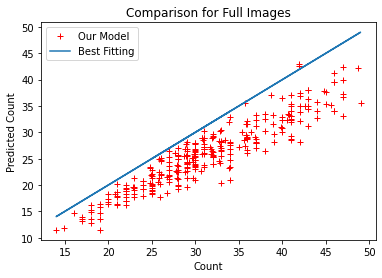

In [ ]:
eval_patch=np.zeros([x_patch.shape[0],2])

In [ ]:
error_patch=0
for i in tqdm(range(x_patch.shape[0])):
    eval_patch[i,0]=np.sum(y_patch[i:i+1])/1000
    eval_patch[i,1]=np.sum(model.predict(x_patch[i:i+1]))/1000
    error_patch+=np.abs((eval_patch[i,0]-eval_patch[i,1]))
print('Mean Absolute Error for the Random Patches in Images: %4.2f' %(error_patch/x_patch.shape[0]))

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:53<00:00, 16.95it/s]

Mean Absolute Error for the Random Patches in Images: 0.44

In [ ]:
plt.plot(eval_patch[:,0],eval_patch[:,1],'r+')
plt.plot(eval_patch[:,0],eval_patch[:,0])
plt.xlabel('Count')
plt.ylabel('Predicted Count')
plt.legend(['Our Model','Best Fitting'])
plt.title('Comparison for Random Patches in Images')

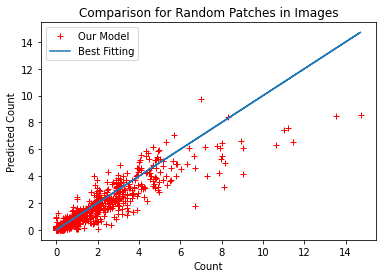

In [ ]:
model.save_weights("Crowd-CNN_v3.h5") #downloading the final model weights for prediction phase

# Video to Image Frames and NPY files (Videoların Fotoğraf Karelerine ve NPY Dosya Formatına döndürülmesi)

Downloading the libraries

In [ ]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
import torch
import cv2
import numpy as np
%matplotlib inline

In [ ]:
vidcap = cv2.VideoCapture('drive/My Drive/Colab Notebooks/crowdZone/bakırköy.mov') # .mov .mp4 and .avi formatted video paths that we would like to get it's frames 
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        path= "image"+str(count)+".png"
        cv2.imwrite(path, image)
        image = np.array(Image.open(path).resize((640,480))) #CNN model except this input shape that's why we resized it.
        np.save("image"+str(count), image)
        # save frame as PNG file, Then NPY file
    return hasFrames
sec = 0
frameRate = 2 #//it will capture image in each 2 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import glob
import os, sys
fpath ="imagecombined.npy" # The name of the single combined npy file we want to get 
npyfilespath ="/content/" # this path contains our NPY files that we saved via previous cell 
os.chdir(npyfilespath)
npfiles= glob.glob("*.npy")
npfiles.sort()
all_arrays = []
for i, npfile in enumerate(npfiles):
    all_arrays.append(np.load(os.path.join(npyfilespath, npfile)))
np.save(fpath, np.concatenate(all_arrays)) #merge all frame information in one NPY file

In [ ]:
vv=np.load("/content/imagecombined.npy") #merged npy file path

In [ ]:
zz=vv.reshape([24,480,640,3]) 
# for the place of "24" value you can write the amount of npy files you had before you merged them together

In [ ]:
plt.imshow(zz[0])

In [ ]:
np.save("drive/My Drive/Colab Notebooks/crowdZone/bakırköy.npy",zz) #saving reshaped merged npy file

# CNN Crowd Counting Model Predictions (CNN Model Tahminlemesi)

In [ ]:
bakırköy=np.load("drive/My Drive/Colab Notebooks/crowdZone/bakırköy.npy")

In [ ]:
img=plt.imshow(bakırköy[12])

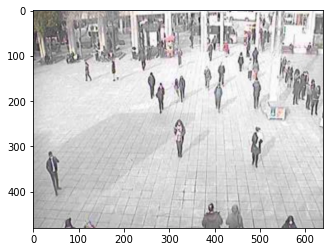

##Model Definition (Modelin Tanımlanması)

In [ ]:
size=(96,128)
input_shape=(size[0],size[1],3)
baseline_vgg=vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
def Crowd_CNN(input_shape=input_shape):
    
    input_flow=Input(input_shape)
    base_filter=8
    
    x_vgg=baseline_vgg.get_layer(index=1)(input_flow)
    for i in range(2,10):
        x_vgg=baseline_vgg.get_layer(index=i)(x_vgg)
        
    
    
    x_1=Conv2D(base_filter*16,9,padding='same',activation='relu')(x_vgg)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(base_filter*8,7,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(1,1,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    
    
    x_2=Conv2D(base_filter*8,7,padding='same',activation='relu')(x_vgg)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(base_filter*2,3,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(1,1,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    
    
    x_3=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_vgg)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(base_filter*2,3,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(base_filter*1,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(1,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    
    x_4=Conv2D(base_filter*4,3,padding='same',activation='relu')(x_vgg)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(base_filter*2,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(base_filter*1,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(1,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    
    
    x_conct=concatenate([x_1,x_2,x_3,x_4])
    x_fel=Flatten()(x_conct)
    x_fel=Dense(base_filter*8,activation='relu')(x_fel)
    x_fel=Dense(4,activation='softmax')(x_fel)
    
    x=Lambda(lambda x: x*(1+x_fel))(x_conct)

    
    x=Conv2D(base_filter*2,5,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=concatenate([x,x_conct])
    x=Conv2D(base_filter*2,3,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2DTranspose(base_filter*2, kernel_size=(2, 2), strides=(2, 2))(x)
    x=BatchNormalization()(x)
    x=Conv2D(base_filter*2,3,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2DTranspose(base_filter, kernel_size=(2, 2), strides=(2, 2))(x)
    x=BatchNormalization()(x)
    x=Conv2D(base_filter,1,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2D(1,1,padding='same',activation='relu')(x)
    
    model=Model(inputs=input_flow,outputs=x)    
    
    return model

## Loss Function and Custom Metric Definition ( Hata Fonksiyonunun ve Metriklerin Tanımlanması)

In [ ]:
def ssim_loss(y_true, y_pred, c1=0.01**2, c2=0.03**2):
    weights_initial = np.multiply(
        cv2.getGaussianKernel(12, 1.5),
        cv2.getGaussianKernel(16, 1.5).T
    )
    weights_initial = weights_initial.reshape(*weights_initial.shape, 1, 1)
    weights_initial = keras.backend.cast(weights_initial, tf.float32)

    mu_F = tf.nn.conv2d(y_pred, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_Y = tf.nn.conv2d(y_true, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_F_mu_Y = tf.multiply(mu_F, mu_Y)
    mu_F_squared = tf.multiply(mu_F, mu_F)
    mu_Y_squared = tf.multiply(mu_Y, mu_Y)

    sigma_F_squared = tf.nn.conv2d(tf.multiply(y_pred, y_pred), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_squared
    sigma_Y_squared = tf.nn.conv2d(tf.multiply(y_true, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_Y_squared
    sigma_F_Y = tf.nn.conv2d(tf.multiply(y_pred, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_mu_Y

    ssim = ((2 * mu_F_mu_Y + c1) * (2 * sigma_F_Y + c2)) / ((mu_F_squared + mu_Y_squared + c1) * (sigma_F_squared + sigma_Y_squared + c2))

    return 1 - tf.reduce_mean(ssim, axis=[1, 2, 3])


def ssim_eucli_loss(y_true, y_pred, alpha=0.0025):
    ssim = ssim_loss(y_true, y_pred)
    eucli = mean_squared_error(y_true, y_pred)
    loss = eucli + alpha * ssim
    return loss

def mae_cnt(labels,preds):
    cnt_label=keras.backend.sum(labels)
    cnt_pred=keras.backend.sum(preds)
    return keras.backend.abs(cnt_label-cnt_pred)

## Model Compile 

In [ ]:
lr=5e-5
model=Crowd_CNN()
model.load_weights("/Users/yesim/Desktop/kodluyoruz/crowd-counting-master/Crowd-CNNvs.h5") #write saved CNN model weight path
Optimizer=Nadam(lr)

In [ ]:
model.compile(optimizer=Optimizer,loss=ssim_eucli_loss,metrics=[mae_cnt])

## Determining Test Size and Data ( Test Boyutuna ve Datasına Karar Verme)

Selecting random data from the bakırköy npy file to test

In [ ]:
#determining the test size and test data
test_size = 1
idx_test = np.random.randint(bakırköy.shape[0], size=test_size)
idx_test #array([12])

In [ ]:
X = bakırköy[idx_test]/255 #normalization

In [ ]:
plt.title("Image for data 0")
plt.imshow(X[0])

Function for predicting on input image(s)

In [ ]:
def full_eval(x,smooth=False):
    y=np.zeros([480,640])
    for i in range(0,480,size[0]):
        for j in range(0,640,size[1]):
            y[i:i+size[0],j:j+size[1]]+=model.predict(x[:,i:i+size[0],j:j+size[1],:])[0,:,:,0]
    if smooth:
        y=ndimage.filters.gaussian_filter(y, 2, mode='constant')
    return y

## Predictions ( Tahminler )

Prediction for all input images (`X`)

In [ ]:
for i in range(0, test_size):
    y_predict = full_eval(X[i:i+1],smooth=True)
    print("Prediction for data {}".format(i))
    print('Predicted Number of people: %4.2f' %(np.sum(y_predict)/1000))

print()

Prediction per single image

In [ ]:
e=0
y_predict=full_eval(X[e:e+1],smooth=True)
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20, 20)) 

# plot for predicted density map
axarr[0].title.set_text('predicted density map')
axarr[0].imshow(X[e,:,:,:])
axarr[0].imshow(y_predict, alpha=0.7)

# plot for actual density map
axarr[1].title.set_text('actual density map')
axarr[1].imshow(X[e,:,:,:])

print('Predicted Number of people: %4.2f' %(np.sum(y_predict)/1000))


Predicted Number of people: 30.45

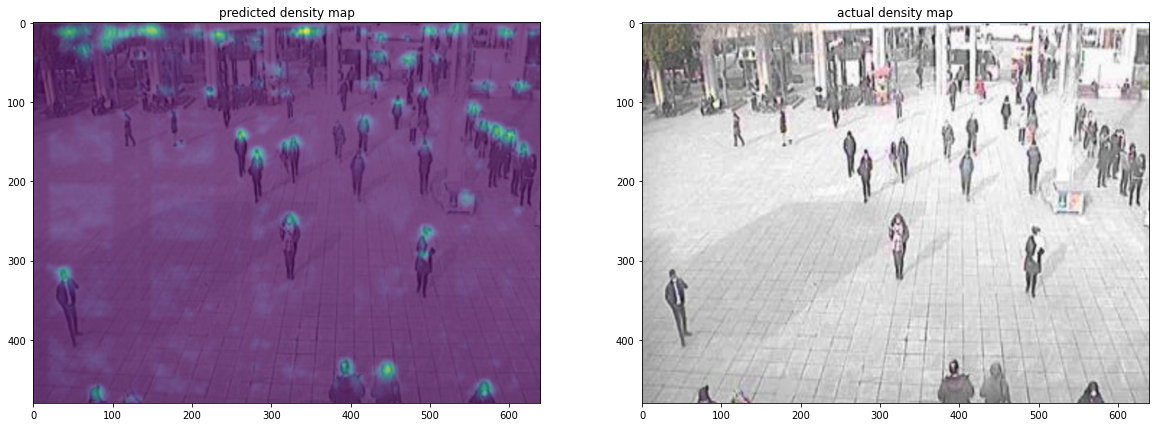